In [1]:
import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import ann
import csv
from typing import Any, Tuple
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import os

c:\Users\79093\.conda\envs\lab\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Разделяем датасет на train test val

In [13]:
splitfolders.ratio('dataset', 'data_set_for_lerning',ratio=(0.8, 0.1, 0.1), seed=13, group_prefix=None)

Copying files: 2200 files [00:04, 510.78 files/s]


## Создание аннотаций 

In [14]:
def create_annotation(subdir:str,label, folderpath, name_csv) -> None:
    with open(f"annotation_{name_csv}.csv", mode="a", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter=";", lineterminator='\n')
        for i in range(2200):
            absolute_way = os.path.abspath(f'{folderpath}/{name_csv}/{subdir}/{i}.jpg')
            if (os.path.isfile(absolute_way)) == True:
                file_writer.writerow([absolute_way,label])

In [15]:
folderpath='data_set_for_lerning'
with open("annotation_train.csv", mode="a", encoding='utf-8') as w_file:
    file_writer = csv.writer(w_file, delimiter=";", lineterminator='\n')
    file_writer.writerow(["folder_path", "label"])
subdir = "CatIT"
create_annotation(subdir,1,folderpath,"train")
subdir = "DogIT"
create_annotation(subdir,0,folderpath,"train")

folderpath='data_set_for_lerning'
with open("annotation_test.csv", mode="a", encoding='utf-8') as w_file:
    file_writer = csv.writer(w_file, delimiter=";", lineterminator='\n')
    file_writer.writerow(["folder_path", "label"])
subdir = "CatIT"
create_annotation(subdir,1,folderpath,"test")
subdir = "DogIT"
create_annotation(subdir,0,folderpath,"test")

folderpath='data_set_for_lerning'
with open("annotation_val.csv", mode="a", encoding='utf-8') as w_file:
    file_writer = csv.writer(w_file, delimiter=";", lineterminator='\n')
    file_writer.writerow(["folder_path", "label"])
subdir = "CatIT"
create_annotation(subdir,1,folderpath,"val")
subdir = "DogIT"
create_annotation(subdir,0,folderpath,"val")

## Сверточная нейросеть Создание собственного набора данных

In [16]:
class CustomImageDataset(Dataset):
  def __init__(self, path_to_annotation_file: str, transform: Any=None, target_transform: Any=None) -> None:
    self.path_to_annotation_file = path_to_annotation_file
    self.dataset_info = pd.read_csv(path_to_annotation_file, delimiter=';')
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self) -> int:
    return len(self.dataset_info)

  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
    path_to_image = self.dataset_info.iloc[index, 0]
    image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
    label = self.dataset_info.iloc[index, 1]

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_Transform(label)
      
    return image, label

In [17]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        
        self.conv_1 = nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2)
        self.conv_2 = nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2)
        self.conv_3 = nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)
        
        self.fc_1 = nn.Linear(576, 10) # 43264 - пока что определяем экспериментальным путем (:
        self.fc_2 = nn.Linear(10, 1)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = self.relu(self.conv_3(output))
        output = self.max_pool(output)

        # print(torch.nn.Flatten()(output).shape) - определить можно, распечатав вот это

        output = torch.nn.Flatten()(output)
        output = self.relu(self.fc_1(output))
        output = torch.nn.Sigmoid()(self.fc_2(output))
        return output

In [18]:
custom_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)), 
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
train_dataset = CustomImageDataset("annotation_train.csv", custom_transforms)
test_dataset = CustomImageDataset("annotation_test.csv", custom_transforms)


In [19]:
device = torch.device(
    "cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = CNN().to(device)
torch.cuda.is_available()

False

In [20]:
device

device(type='cpu')

In [21]:
custom_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize(
                                                        (224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
train_dataset = CustomImageDataset( 'annotation_train.csv', custom_transforms)
test_dataset = CustomImageDataset('annotation_test.csv', custom_transforms)
val_dataset = CustomImageDataset('annotation_val.csv', custom_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

## loop 1

In [22]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCaset
epochs = 20
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataset)
        epoch_loss += loss / len(train_dataset)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataset)
        epoch_val_loss += loss_val / len(val_dataset)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

Epoch : 1, train accuracy : 0.5500000000000007, train loss : 0.6829659342765808
Epoch : 1, val accuracy : 0.6499999999999998, val loss : 0.6483985781669617
Epoch : 2, train accuracy : 0.6403409090909098, train loss : 0.6415196657180786
Epoch : 2, val accuracy : 0.7090909090909091, val loss : 0.5720923542976379
Epoch : 3, train accuracy : 0.7204545454545466, train loss : 0.5579677820205688
Epoch : 3, val accuracy : 0.7181818181818183, val loss : 0.5601474642753601
Epoch : 4, train accuracy : 0.7778409090909105, train loss : 0.47159481048583984
Epoch : 4, val accuracy : 0.7681818181818183, val loss : 0.46952125430107117
Epoch : 5, train accuracy : 0.8136363636363657, train loss : 0.3968522846698761
Epoch : 5, val accuracy : 0.7454545454545457, val loss : 0.4939405024051666
Epoch : 6, train accuracy : 0.8465909090909114, train loss : 0.34472888708114624
Epoch : 6, val accuracy : 0.7272727272727274, val loss : 0.5445854663848877
Epoch : 7, train accuracy : 0.8869318181818215, train loss : 

### графики

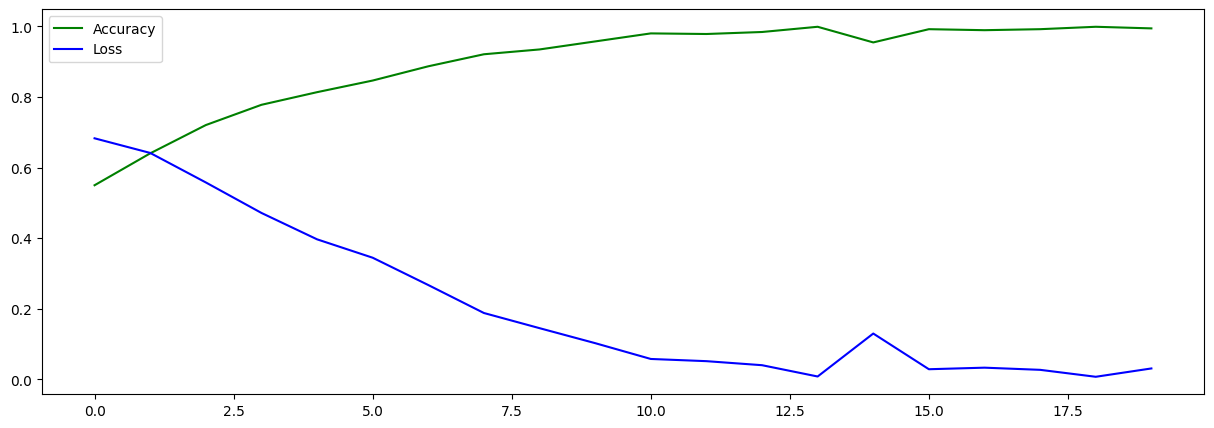

In [23]:
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.plot(range(len(accuracy_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Accuracy", "Loss"])

### Тестовые данные 

In [24]:
model.eval()

test_loss = 0
test_accuracy = 0
    
for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).mean()
    test_accuracy += acc / len(test_dataloader)
    test_loss += float(loss.detach()) / len(test_dataloader)
f"test_accuracy={ test_accuracy} test_loss={test_loss}"

'test_accuracy=0.8181818181818182 test_loss=0.07986241579055788'

## Loop 2 

In [26]:
train_dataset = CustomImageDataset('annotation_train.csv', custom_transforms)
test_dataset = CustomImageDataset('annotation_test.csv', custom_transforms)
val_dataset = CustomImageDataset('annotation_val.csv', custom_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=False)
optimizer = optim.Adam(params=model.parameters(), lr=0.005)
criterion = nn.BCELoss()
epochs = 9
#model.train()
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuraset
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataset)
        epoch_loss += loss / len(train_dataset)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataset)
        epoch_val_loss += loss_val / len(val_dataset)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

Epoch : 1, train accuracy : 0.9399092970521562, train loss : 0.17727386951446533
Epoch : 1, val accuracy : 0.7927927927927927, val loss : 0.8620625138282776
Epoch : 2, train accuracy : 0.9529478458049903, train loss : 0.13404719531536102
Epoch : 2, val accuracy : 0.7297297297297298, val loss : 0.6524004936218262
Epoch : 3, train accuracy : 0.954081632653063, train loss : 0.12435563653707504
Epoch : 3, val accuracy : 0.743243243243243, val loss : 0.7252705693244934
Epoch : 4, train accuracy : 0.9659863945578248, train loss : 0.10873448103666306
Epoch : 4, val accuracy : 0.7747747747747749, val loss : 0.7755078077316284
Epoch : 5, train accuracy : 0.9648526077097521, train loss : 0.10976986587047577
Epoch : 5, val accuracy : 0.8018018018018018, val loss : 0.779073178768158
Epoch : 6, train accuracy : 0.9761904761904777, train loss : 0.06637542694807053
Epoch : 6, val accuracy : 0.7409909909909909, val loss : 2.158599615097046
Epoch : 7, train accuracy : 0.9501133786848089, train loss : 0

### График

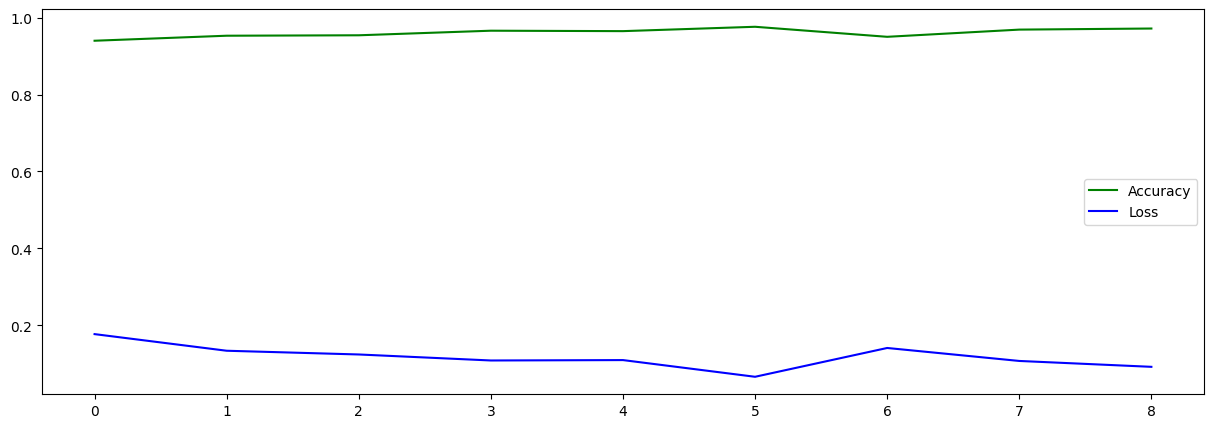

In [27]:
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.plot(range(len(accuracy_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Accuracy", "Loss"])

### На тестовых данных

In [33]:
model.eval()
test_loss = 0
test_accuracy = 0

for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)

    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
        label[j]) else 0 for j in range(4)])).mean()
    test_accuracy += acc / len(test_dataloader)
    test_loss += float(loss.detach()) / len(test_dataloader)
print('test_accuracy=', test_accuracy, ' ', 'test_loss=', test_loss)

test_accuracy= 0.7500000000000002   test_loss= 0.279804766178131


## Loop 3

In [46]:
train_dataset = CustomImageDataset('annotation_train.csv', custom_transforms)
test_dataset = CustomImageDataset('annotation_test.csv', custom_transforms)
val_dataset = CustomImageDataset('annotation_val.csv', custom_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=False)
optimizer = optim.Adam(params=model.parameters(), lr=0.005)
criterion = nn.BCELoss()
epochs = 9
#model.train()
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataset)
        epoch_loss += loss / len(train_dataset)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataset)
        epoch_val_loss += loss_val / len(val_dataset)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

Epoch : 1, train accuracy : 0.9688208616780062, train loss : 0.6731207966804504
Epoch : 1, val accuracy : 0.7522522522522521, val loss : 5.107797622680664
Epoch : 2, train accuracy : 0.9807256235827677, train loss : 0.08388323336839676
Epoch : 2, val accuracy : 0.7972972972972974, val loss : 1.743675708770752
Epoch : 3, train accuracy : 0.9920634920634933, train loss : 0.021553047001361847
Epoch : 3, val accuracy : 0.7972972972972969, val loss : 2.6318392753601074
Epoch : 4, train accuracy : 0.9886621315192755, train loss : 0.04213094338774681
Epoch : 4, val accuracy : 0.7477477477477477, val loss : 2.2965078353881836
Epoch : 5, train accuracy : 0.9914965986394568, train loss : 0.026618268340826035
Epoch : 5, val accuracy : 0.8198198198198199, val loss : 2.564634084701538
Epoch : 6, train accuracy : 0.9994331065759647, train loss : 0.0013763181632384658
Epoch : 6, val accuracy : 0.7792792792792791, val loss : 1.9744892120361328
Epoch : 7, train accuracy : 0.9875283446712031, train loss

### График

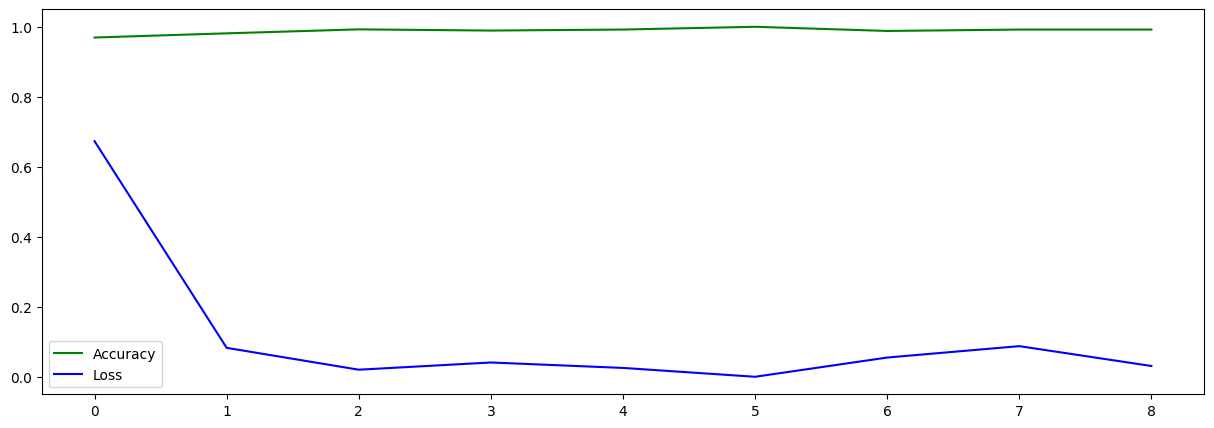

In [47]:
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.plot(range(len(accuracy_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Accuracy", "Loss"])

### На тестовых данных

In [48]:
model.eval()
test_loss = 0
test_accuracy = 0

for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)

    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
        label[j]) else 0 for j in range(4)])).mean()
    test_accuracy += acc / len(test_dataloader)
    test_loss += float(loss.detach()) / len(test_dataloader)
print('test_accuracy=', test_accuracy, ' ', 'test_loss=', test_loss)

test_accuracy= 0.7500000000000001   test_loss= 0.0004400460456963627


## Сохранение Модели

In [49]:
torch.save(model.state_dict(), os.path.join("dataset", "weight.pt"))

## Загрузка модели

In [50]:
model = CNN()
model.load_state_dict(torch.load(os.path.join("dataset", "weight.pt")))

<All keys matched successfully>

## Проверка модели на тестовых данных

In [51]:
model.eval()

test_loss = 0
test_accuracy = 0
    
for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).mean()
    test_accuracy += acc / len(test_dataloader)
    test_loss += float(loss.detach()) / len(test_dataloader)

    
test_accuracy, test_loss

(0.7500000000000001, 0.0004400460456963627)

## Пользуемся !

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


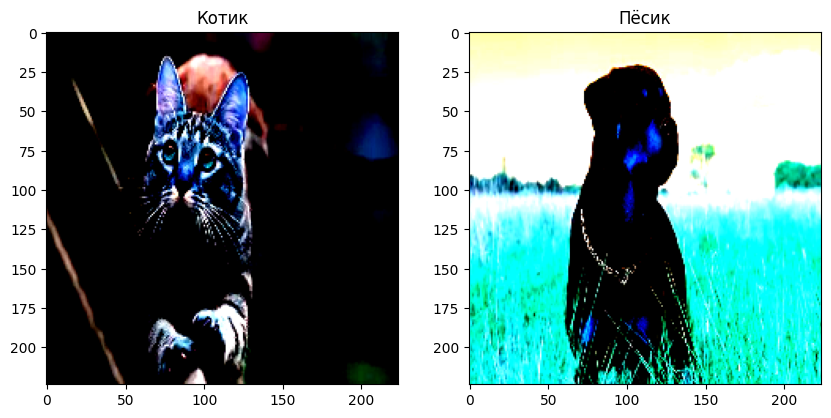

In [64]:
import random
plt.figure(figsize=(10, 5))

for j in range(2):
  index = random.randint(0, 200)
  plt.subplot(1, 2, j + 1)
  plt.title("Пёсик" if (1 if  model(test_dataset[index][0].unsqueeze(dim=0))[0] >= 0.5 else 0) == 0 else "Котик")
  plt.imshow(test_dataset[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])